<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>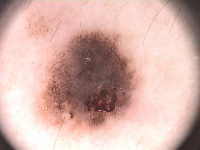</td><td>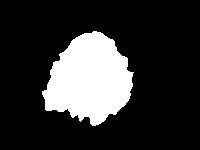</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

In [ ]:
!ls

In [ ]:
!apt-get update
!apt-get install -y unrar

In [ ]:
!unrar x PH2Dataset.rar

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

In [ ]:
len(lesions)

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs[:, 1, :, :].squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels[:, 1, :, :].squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))       # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou 

In [ ]:
def bce_losse(input, target):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = -target * torch.log(input + 1e-7) - (1 - target) * torch.log(1 - input + 1e-7)
    return torch.mean(loss)

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.argmax(model(X_batch), dim=1).detach().cpu() for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_label_2 = torch.ones(Y_label.size(), dtype=torch.float, device=device)
        Y_label_2 = Y_label_2 - Y_label
        Y_label = torch.cat((Y_label, Y_label_2), dim=1)
        Y_pred = model(X_batch)
        Y_pred = Y_pred.to(dtype=torch.float)
        scores += metric(torch.round(Y_pred), Y_label).mean().item()
    return scores/len(data)

In [ ]:
def count_params(model):
    total = 0
    for param in model.parameters():
        total += param.numel()
    print('Total parameters of a model:', total)
#count_params(model)

In [ ]:
# if there is huge peek at the start just set start to some epoch after that peek
def visualise(start, steps, train_loss, val_loss, train_score, val_score):
    start=0
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax1, ax2 = ax[0], ax[1]
    ax1.plot(steps[start:], train_loss[start:], color='r', label='Train Loss')
    ax1.plot(steps[start:], val_loss[start:], color='g', label='Validation Loss')
    ax1.legend()
    ax2.plot(steps[start:], train_score[start:], color='r', label='Train Score')
    ax2.plot(steps[start:], val_score[start:], color='g', label='Validation Score')
    ax2.legend()

    plt.show()

In [ ]:
import gc
def cleanup(model):
    del model
    torch.cuda.empty_cache()
    gc.collect()
#cleanup(model)

In [ ]:
def dice_loss(outputs : torch.Tensor, labels : torch.Tensor, slide=1):
    n, m = outputs.size()[-2:]
    num = (2*outputs * labels).sum((1, 2, 3)) + slide
    den = (outputs + labels).sum((1, 2, 3)) + slide
    res = 1 - (num/den).mean()
    return res

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-7, gamma = 2):
    y_pred = torch.clamp(y_pred, eps, 1-eps)
    loss = -((1-y_pred)**gamma * y_real * torch.log(y_pred) + (1-y_real) * torch.log(1 - y_pred)).mean((1, 2, 3))
    loss = loss.mean()
    return loss

In [ ]:
class TLoss(nn.Module):
    def __init__(self, config, nu: float = 1.0, epsilon: float = 1e-8, rank=50, reduction: str = "mean"):
        super().__init__()
        self.config = config
        self.rank = rank
      
        self.attention = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3), padding=3, dilation=3, device=config['device']),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=(3, 3), padding=3, dilation=3, device=config['device']),
        nn.ReLU(),
        nn.Conv2d(16, 8, kernel_size=(3, 3), padding=3, dilation=3, device=config['device']),
        nn.ReLU(),
        nn.Conv2d(8, 1, kernel_size=(3, 3), padding=3, dilation=3, device=config['device']),
        nn.ReLU()
        )
        self.D = torch.tensor(
            (self.config['data']['image_size'] * self.config['data']['image_size']),
            dtype=torch.float,
            device=config['device'],
        )
        self.lambdas = torch.ones(
            (self.config['data']['image_size'], self.config['data']['image_size']),
            dtype=torch.float,
            device=config['device'],
        ) # was not in paper, I don't know what is it but forced to copy it. 
        # maybe the mistake in paper and by identity matrix author meaned matrix of ones
        
        # степень свободы подбирается сама
        self.nu = nn.Parameter(
            torch.tensor(nu, dtype=torch.float, device=config['device'], requires_grad=True)
        )
        self.epsilon = torch.tensor(epsilon, dtype=torch.float, device=config['device'])
        self.reduction = reduction      
    
    def forward(self, input_tensor: torch.Tensor, target_tensor: torch.Tensor, x_tensor: torch.Tensor) -> torch.Tensor:
        C = self.attention(x_tensor).mean(dim=0).squeeze(dim=0)
        sigma = torch.eye(256, dtype=torch.float, device=self.config['device']) + C
        delta_i = input_tensor - target_tensor
        sum_nu_epsilon = torch.exp(self.nu) + self.epsilon
        first_term = -torch.lgamma((sum_nu_epsilon + self.D) / 2)
        second_term = torch.lgamma(sum_nu_epsilon / 2)
        third_term = 0.5 * torch.log(torch.clamp(torch.det(sigma), min=self.epsilon))
        fourth_term = (self.D / 2) * torch.log(torch.tensor(np.pi))
        fifth_term = (self.D / 2) * (self.nu + self.epsilon) # comes from 4-th term in original paper
        delta_squared = torch.transpose(delta_i, dim0=2, dim1=3) @ torch.inverse(sigma) @ delta_i
        lambdas_exp = torch.exp(sigma + self.epsilon)  # was not in paper, don't know
        numerator = delta_squared * lambdas_exp  # was not in paper, don't know
        numerator = torch.sum(numerator, dim=(1, 2, 3))  # was not in paper, don't know
        fraction = numerator / sum_nu_epsilon
        sixth_term = ((sum_nu_epsilon + self.D) / 2) * torch.log(torch.clamp(1 + fraction, min=self.epsilon))
        total_losses = (
            first_term
            + second_term
            + third_term
            + fourth_term
            + fifth_term
            + sixth_term
        )
        
        if self.reduction == "mean":
            return total_losses.mean()
        elif self.reduction == "sum":
            return total_losses.sum()
        elif self.reduction == "none":
            return total_losses
        else:
            raise ValueError(
                f"The reduction method '{self.reduction}' is not implemented."
            )

In [ ]:
class TLossMy(nn.Module):
    def __init__(self, config, nu: float = 1.0, epsilon: float = 1e-8, rank=50, reduction: str = "mean"):
        super().__init__()
        self.config = config
        self.rank = rank
        self.D = torch.tensor(
            (self.config['data']['image_size'] * self.config['data']['image_size']),
            dtype=torch.float,
            device=config['device'],
        )
        self.lambdas = torch.ones(
            (self.config['data']['image_size'], self.config['data']['image_size']),
            dtype=torch.float,
            device=config['device'],
        ) # was not in paper, I don't know what is it but forced to copy it. 
        # maybe the mistake in paper and by identity matrix author meaned matrix of ones
        
        # степень свободы подбирается сама
        self.nu = nn.Parameter(
            torch.tensor(nu, dtype=torch.float, device=config['device'], requires_grad=True)
        )
        self.A = nn.Parameter(
            torch.ones(256, rank, dtype=torch.float, device=config['device'], requires_grad=True)/256
        )
        self.B = nn.Parameter(
            torch.ones(rank, 256, dtype=torch.float, device=config['device'], requires_grad=True)/256
        )
        self.epsilon = torch.tensor(epsilon, dtype=torch.float, device=config['device'])
        self.reduction = reduction
        

    def forward(
        self, input_tensor: torch.Tensor, target_tensor: torch.Tensor
    ) -> torch.Tensor:
        sigma = torch.abs(self.A @ self.B - self.rank*torch.ones(256, 256, dtype=torch.float, device=self.config['device'])/256**2) + torch.eye(256, dtype=torch.float, device=self.config['device'])
        delta_i = input_tensor - target_tensor
        sum_nu_epsilon = torch.exp(self.nu) + self.epsilon
        first_term = -torch.lgamma((sum_nu_epsilon + self.D) / 2)
        second_term = torch.lgamma(sum_nu_epsilon / 2)
        third_term = 0.5 * torch.log(torch.clamp(torch.det(sigma), min=self.epsilon))
        fourth_term = (self.D / 2) * torch.log(torch.tensor(np.pi))
        fifth_term = (self.D / 2) * (self.nu + self.epsilon) # comes from 4-th term in original paper
        delta_squared = torch.transpose(delta_i, dim0=2, dim1=3) @ torch.inverse(sigma) @ delta_i
        lambdas_exp = torch.exp(sigma + self.epsilon)  # was not in paper, don't know
        numerator = delta_squared * lambdas_exp  # was not in paper, don't know
        numerator = torch.sum(numerator, dim=(1, 2, 3))  # was not in paper, don't know
        fraction = numerator / sum_nu_epsilon
        sixth_term = ((sum_nu_epsilon + self.D) / 2) * torch.log(torch.clamp(1 + fraction, min=self.epsilon))
        total_losses = (
            first_term
            + second_term
            + third_term
            + fourth_term
            + fifth_term
            + sixth_term
        )
        
        if self.reduction == "mean":
            return total_losses.mean()
        elif self.reduction == "sum":
            return total_losses.sum()
        elif self.reduction == "none":
            return total_losses
        else:
            raise ValueError(
                f"The reduction method '{self.reduction}' is not implemented."
            )

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

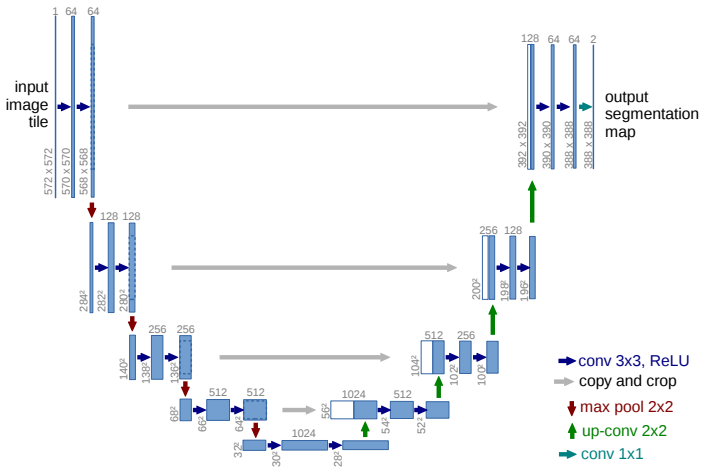

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self, input_layers=3, hidden=64, kernel_size=(3, 3), n_classes=2, padding=1, stride=1, bias=False):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.lastbottleneck = nn.Sequential(
            nn.Conv2d(hidden, hidden//4, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(hidden//4),
            nn.ReLU(),
            nn.Conv2d(hidden//4, n_classes, kernel_size=(3, 3), padding=1)
        )

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(input_layers, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d((2, 2), stride=2, return_indices=True)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)

        self.bottleneck_enc_conv = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )

        self.bottleneck_dec_conv = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample =  nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(2*hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(2*hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(2*hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(2*hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, bias=bias, stride=stride, padding=padding, dtype=torch.float),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )
        self.logit_fn = nn.Softmax(dim=1)

    def forward(self, x):
        # encoder
        x0 = self.enc_conv0(x)
        x0_size = x0.size()
        x, indc1 = self.pool0(x0)
        x1 = self.enc_conv1(x)
        x1_size = x1.size()
        x, indc2 = self.pool1(x1)
        x2 = self.enc_conv2(x)
        x2_size = x2.size()
        x, indc3 = self.pool2(x2)
        x3 = self.enc_conv3(x)
        x3_size = x3.size()
        x, indc4 = self.pool3(x3)

        x = self.bottleneck_enc_conv(x)
        x = self.bottleneck_dec_conv(x)

        # decoder
        x = self.upsample(x, indices=indc4, output_size=x3_size)
        x = self.dec_conv0(torch.cat((x, x3), dim = 1))
        x = self.upsample(x, indices=indc3, output_size=x2_size)
        x = self.dec_conv1(torch.cat((x, x2), dim = 1))
        x = self.upsample(x, indices=indc2, output_size=x1_size)
        x = self.dec_conv2(torch.cat((x, x1), dim = 1))
        x = self.upsample(x, indices=indc1, output_size=x0_size)
        x = self.dec_conv3(torch.cat((x, x0), dim = 1))

        x = self.lastbottleneck(x)
        x = self.logit_fn(x)
        return x

In [ ]:
def train(epochs, model, data_tr, data_val, metric, optim1, optim2):
    loss_train, loss_val = [], []
    train_score, val_score = [], []
    optimizer_model = optim1
    optimizer_loss = optim2
    loss_fn = metric

    def update_stats(epoch, loss_tr, loss_vl, score_tr, score_vl):
        loss_train.append(loss_tr.cpu().tolist())
        loss_val.append(loss_vl.cpu().tolist())
        train_score.append(score_tr)
        val_score.append(score_vl)

    for epoch in range(epochs):
        #print('After training:', tloss.A[0])
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_score_train = 0
        model.train()  # train mode
        X_val, Y_val = next(iter(data_val))
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_batch_2 = torch.ones(Y_batch.size(), dtype=torch.float, device=device)
            Y_batch_2 = Y_batch_2 - Y_batch
            # set parameter gradients to zero
            optimizer_model.zero_grad()
            optimizer_loss.zero_grad()
            # forward
            Y_batch = torch.cat((Y_batch, Y_batch_2), dim=1)
            Y_pred = model(X_batch)
            Y_pred = Y_pred.to(dtype=torch.float)
            loss = loss_fn(Y_pred, Y_batch, X_batch) # forward-pass  # backward-pass
            loss.backward()
            optimizer_model.step()  # update weights
            optimizer_loss.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_score_train += iou_pytorch(torch.round(Y_pred), Y_batch).mean().item() / len(data_tr)
            X_batch.to('cpu')
            Y_batch.to('cpu')
            Y_batch_2.to('cpu')
            Y_pred.to('cpu')
            del Y_batch_2
            del X_batch
            del Y_batch
            del Y_pred
        toc = time()
        print('loss: %f' % avg_loss)
        avg_val_loss = 0
        avg_score_val = 0
        for X_valid, Y_valid in data_val:
            model.eval()
            X_valid = X_valid.to(device)
            Y_valid = Y_valid.to(device)
            Y_hat = model(X_valid)
            Y_hat = Y_hat.to(dtype=torch.float)
            Y_valid_2 = torch.ones(Y_valid.size(), dtype=torch.float, device=device)
            Y_valid_2 = Y_valid_2 - Y_valid
            Y_valid = torch.cat((Y_valid, Y_valid_2), dim=1)
            avg_val_loss += loss_fn(Y_hat, Y_valid, X_valid) / len(data_val)
            avg_score_val += iou_pytorch(torch.round(Y_hat), Y_valid).mean().item() / len(data_val)
            X_valid.to('cpu')
            Y_valid.to('cpu')
            Y_valid_2.to('cpu')
            Y_hat.to('cpu')
            del X_valid
            del Y_valid
            del Y_valid_2
            del Y_hat

        update_stats(epoch, avg_loss, avg_val_loss, avg_score_train, avg_score_val)
        model.eval()
        Y_hat = model(X_val)
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(torch.round(Y_hat).detach().cpu().numpy()[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
            plt.subplot(3, 6, k+13)
            plt.imshow(np.rollaxis(Y_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        plt.suptitle('%d / %d - train loss: %f, val score: %g' % (epoch+1, epochs, avg_loss, avg_score_val))
        plt.show()


        Y_hat.to('cpu')
        Y_val.to('cpu')
        X_val.to('cpu')
        del X_val
        del Y_hat
        del Y_val
    return list(range(epochs)), loss_train, loss_val, train_score, val_score


In [ ]:
unet_model = UNet(hidden=32).to(device)

In [ ]:
config = {'data': {'image_size': 256}, 'device': device}
tloss = TLoss(config)
print('Before training:', tloss.nu)

In [ ]:
#print('Before training:', tloss.B[0])

In [ ]:
optim_loss = torch.optim.Adam(tloss.parameters())
optim_model = torch.optim.Adam(unet_model.parameters())

In [ ]:
max_epochs = 100
steps, train_history, val_history, train_score_history, val_score_history = train(max_epochs, unet_model, data_tr, data_val, tloss, optim_model, optim_loss)
unet_tloss_test_score = score_model(unet_model, iou_pytorch, data_ts)
#cleanup(unet_model)

In [ ]:
print(unet_tloss_test_score)

In [ ]:
visualise(0, steps, train_history, val_history, train_score_history, val_score_history)

In [ ]:
print('After training:', tloss.nu)

In [ ]:
print('After training:', tloss.A @ tloss.B - torch.ones(256, device=device)/(256**2))

In [ ]:
cleanup(unet_model)

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Score comparison (score : intersection / union)

# Анализ моделей с одинаковой функцией лосса

# Заключение и общие выводы
Проведенный эксперимент рассматривал две нейроные модели Segnet, UNet. При этом каждая их перечисленных моделей тестировалась с 4-мя разными типами функции потерь, а именно: BCE, Dice, Focal и T-Loss при неизменных других параметрах, таких как количество эпох, скорость обучения, тип оптимизатора и т.п. Библиотечные реализации лосс-функций НЕ использовались. 

Вывод эксперимента очевиден: явного лидера среди моделей нет - и на это есть причина.
Когда то в статье или учебнике я читал, что skip-connections работает на больших моделях, где затухают градиенты, но так как выбрана легкая архитектура, то их наличие не оказало влияние, что тоже можно небольшим достижением в исследовании отличия UNet от SegNet. 
Dice/T-Loss можно охарактеризовать как оптимальный выбор для любой архитектуры. При обучении моделей использовался оптимизатор adam, параметры которого подбирались несколькими итерациями в процессе обучения моделей для получения наибольших значений score.

Обучение всех 8 моделей проводено в Kaggle Notebook за 1 сеанс, что потребовало пристального внимания за наполнением\очисткой выделенной VRAM. Внутри каждого цикла обучения высвобождается VRAM на GPU от различных батч-данных, а также, после обучения конкретной модели требовался её перенос на CPU с последующим удалением и очисткой кеша. При этого каждой цикл обучения по 100 эпохам на GPU занимал около *3* минут.